In [2]:
from imports import *

# Fetch dataset

In [3]:
r = 0.5
target_anomaly_rate = r

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
df_normal = df_normal.sample(frac=0.08, random_state=1)
n_records = int(np.ceil(len(df_normal)*r/(1-r)))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train, x_test, y_train, y_test = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 50.0% out of 155644 records (77822)


Just like with sklearn SA dataset, we selected all of the 'normal' data with a small portion of outliers to reach our target anomaly rate

# Cross-validation for Isolation Forest

In [3]:
def cross_validation(contamination):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"Finished trainning in {t} seconds")
        print(f"contamination: {c} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [4]:
print(set(np.array(y_test)))

{1, -1}


In [5]:
contamination = [0.01]
c_max = cross_validation(contamination)
c_max

1811
Finished trainning in 0:02:13.392060 seconds
contamination: 0.01 	 tp: 1811/support: 160132/predicted: 4780 -> fp = 2969
AUC : 50.1% 	 precision: 0.379 	 recall: 0.0113 	 f1: 0.021963228873581063
--------------------


0.01

In [ ]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation(contamination)
c_max

1811
Finished trainning in 0:02:13.593566 seconds
contamination: 0.01 	 tp: 1811/support: 160132/predicted: 4780 -> fp = 2969
AUC : 50.1% 	 precision: 0.379 	 recall: 0.0113 	 f1: 0.021963228873581063
--------------------
2596
Finished trainning in 0:02:13.651242 seconds
contamination: 0.02 	 tp: 2596/support: 160132/predicted: 9511 -> fp = 6915
AUC : 49.7% 	 precision: 0.273 	 recall: 0.0162 	 f1: 0.03060544791120176
--------------------
3454
Finished trainning in 0:02:13.717577 seconds
contamination: 0.03 	 tp: 3454/support: 160132/predicted: 14335 -> fp = 10881
AUC : 49.4% 	 precision: 0.241 	 recall: 0.0216 	 f1: 0.039594880407183015
--------------------
4689
Finished trainning in 0:02:13.473720 seconds
contamination: 0.04 	 tp: 4689/support: 160132/predicted: 19136 -> fp = 14447
AUC : 49.2% 	 precision: 0.245 	 recall: 0.0293 	 f1: 0.0523127384697771
--------------------
6549
Finished trainning in 0:02:13.423068 seconds
contamination: 0.05 	 tp: 6549/support: 160132/predicted: 241

In [4]:
contamination = [round(0.1*i, 1) for i in range(1, 7)]
c_max_2 = cross_validation(contamination)
c_max_2

13075
Finished trainning in 0:02:13.593435 seconds
contamination: 0.1 	 tp: 13075/support: 160132/predicted: 48330 -> fp = 35255
AUC : 48.6% 	 precision: 0.271 	 recall: 0.0817 	 f1: 0.12544252669551287
--------------------
32505
Finished trainning in 0:02:13.677826 seconds
contamination: 0.2 	 tp: 32505/support: 160132/predicted: 96032 -> fp = 63527
AUC : 50.3% 	 precision: 0.338 	 recall: 0.203 	 f1: 0.2537827329367124
--------------------
54196
Finished trainning in 0:02:13.497355 seconds
contamination: 0.3 	 tp: 54196/support: 160132/predicted: 139305 -> fp = 85109
AUC : 53.7% 	 precision: 0.389 	 recall: 0.338 	 f1: 0.3619859937148716
--------------------
70637
Finished trainning in 0:02:13.196099 seconds
contamination: 0.4 	 tp: 70637/support: 160132/predicted: 192072 -> fp = 121435
AUC : 53.2% 	 precision: 0.368 	 recall: 0.441 	 f1: 0.4011141270400109
--------------------
81425
Finished trainning in 0:02:13.375726 seconds
contamination: 0.5 	 tp: 81425/support: 160132/predicted

0.5

In [5]:
contamination = [round(c_max_2 - 0.1 + 0.01*i, 2) for i in range(11)]
c_max = cross_validation(contamination)
c_max

70637
Finished trainning in 0:02:13.109373 seconds
contamination: 0.4 	 tp: 70637/support: 160132/predicted: 192072 -> fp = 121435
AUC : 53.2% 	 precision: 0.368 	 recall: 0.441 	 f1: 0.4011141270400109
--------------------
70637
Finished trainning in 0:02:13.040052 seconds
contamination: 0.41 	 tp: 70637/support: 160132/predicted: 196392 -> fp = 125755
AUC : 52.5% 	 precision: 0.36 	 recall: 0.441 	 f1: 0.3962538286342574
--------------------
70637
Finished trainning in 0:02:12.903651 seconds
contamination: 0.42 	 tp: 70637/support: 160132/predicted: 201702 -> fp = 131065
AUC : 51.7% 	 precision: 0.35 	 recall: 0.441 	 f1: 0.3904387094634556
--------------------
70637
Finished trainning in 0:02:12.966043 seconds
contamination: 0.43 	 tp: 70637/support: 160132/predicted: 206362 -> fp = 135725
AUC : 50.9% 	 precision: 0.342 	 recall: 0.441 	 f1: 0.385474250601647
--------------------
70637
Finished trainning in 0:02:12.947277 seconds
contamination: 0.44 	 tp: 70637/support: 160132/predi

0.48

In [ ]:
c_max = 0.25

trained isolation forest in: 0:02:12.565903
AUC: 51.7%
              precision    recall  f1-score   support

          -1       0.35      0.51      0.41    160132
           1       0.68      0.53      0.59    321395

    accuracy                           0.52    481527
   macro avg       0.52      0.52      0.50    481527
weighted avg       0.57      0.52      0.53    481527



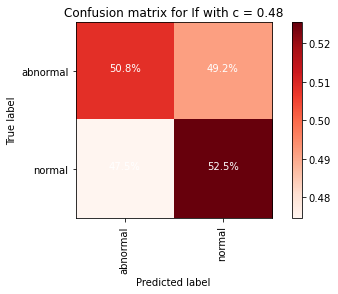

In [6]:
s = datetime.datetime.now()
y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c_max).fit(x_train).predict(x_test)
t = datetime.datetime.now() - s
cm_if = confusion_matrix(y_test, y_pred)
print(f"trained isolation forest in: {t}")
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm_if, f"Confusion matrix for If with c = {c_max}")

## Cross validation for LOF 

In [3]:
def cross_validation_lof(contamination):
    highest_score = 0
    highest_score_c = 0
    #print("array:", contamination)
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"Finished trainning in {t} seconds")
        print(f"contamination: {c} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [4]:
contamination = [round(0.1 + 0.1*i, 2) for i in range(5)]
c_max = cross_validation_lof(contamination)
c_max

Finished trainning in 0:12:38.481717 seconds
contamination: 0.1 	 tp: 7282/support: 160132/predicted: 48153 -> fp = 40871
AUC : 45.9% 	 precision: 0.151 	 recall: 0.0455 	 f1: 0.06992342223395827
--------------------
Finished trainning in 0:12:39.043692 seconds
contamination: 0.2 	 tp: 12461/support: 160132/predicted: 96306 -> fp = 83845
AUC : 40.8% 	 precision: 0.129 	 recall: 0.0778 	 f1: 0.09718528455221145
--------------------
Finished trainning in 0:12:38.488800 seconds
contamination: 0.3 	 tp: 17647/support: 160132/predicted: 144458 -> fp = 126811
AUC : 35.8% 	 precision: 0.122 	 recall: 0.11 	 f1: 0.11587379756393841
--------------------
Finished trainning in 0:12:36.180096 seconds
contamination: 0.4 	 tp: 23161/support: 160132/predicted: 192611 -> fp = 169450
AUC : 30.9% 	 precision: 0.12 	 recall: 0.145 	 f1: 0.13131940251117669
--------------------
Finished trainning in 0:12:35.131759 seconds
contamination: 0.5 	 tp: 31059/support: 160132/predicted: 240763 -> fp = 209704
AUC 

0.1

In [5]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation_lof(contamination)
c_max

Finished trainning in 0:12:38.465320 seconds
contamination: 0.01 	 tp: 1097/support: 160132/predicted: 4796 -> fp = 3699
AUC : 49.8% 	 precision: 0.229 	 recall: 0.00685 	 f1: 0.013302774544043463
--------------------
Finished trainning in 0:12:37.706760 seconds
contamination: 0.02 	 tp: 1891/support: 160132/predicted: 9631 -> fp = 7740
AUC : 49.4% 	 precision: 0.196 	 recall: 0.0118 	 f1: 0.022278117139777218
--------------------
Finished trainning in 0:12:38.675098 seconds
contamination: 0.03 	 tp: 3032/support: 160132/predicted: 14446 -> fp = 11414
AUC : 49.2% 	 precision: 0.21 	 recall: 0.0189 	 f1: 0.034735190001031056
--------------------
Finished trainning in 0:12:37.482743 seconds
contamination: 0.04 	 tp: 3745/support: 160132/predicted: 19262 -> fp = 15517
AUC : 48.8% 	 precision: 0.194 	 recall: 0.0234 	 f1: 0.041751675083893554
--------------------
Finished trainning in 0:12:39.715872 seconds
contamination: 0.05 	 tp: 4363/support: 160132/predicted: 24077 -> fp = 19714
AUC :

0.01

In [ ]:
c_max = 0.3

In [ ]:
contamination = [round(c_max-0.01 + 0.001*i, 3) for i in range(1,10)]
c_max = cross_validation_lof(contamination)
c_max

In [ ]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=0.5, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

In [ ]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c_max, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

# DBSCAN

Tested parameters: 
* eps

In [4]:
def cross_validation_dbscan(eps):
    highest_score = 0
    best_eps = 0
    for e in eps:
        s = datetime.datetime.now()
        db = DBSCAN(eps=e, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
        y_pred = [1 if i != -1 else i for i in db.labels_]
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; best_eps = e
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"Finished trainning in {t} seconds")
        print(f"eps: {e} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return best_eps

In [5]:
eps = [round(0.1 + 0.1*i, 1) for i in range(5)]
e_max = cross_validation_dbscan(eps)
e_max

7356
Finished trainning in 0:00:10.389872 seconds
eps: 0.1 	 tp: 7356/support: 25629/predicted: 31558 -> fp = 24202
AUC : 17.3% 	 precision: 0.233 	 recall: 0.287 	 f1: 0.25726126567226815
--------------------
7329
Finished trainning in 0:00:10.046870 seconds
eps: 0.2 	 tp: 7329/support: 25629/predicted: 31398 -> fp = 24069
AUC : 17.5% 	 precision: 0.233 	 recall: 0.286 	 f1: 0.2570361407754222
--------------------
7308
Finished trainning in 0:00:09.777310 seconds
eps: 0.3 	 tp: 7308/support: 25629/predicted: 31352 -> fp = 24044
AUC : 17.5% 	 precision: 0.233 	 recall: 0.285 	 f1: 0.2565065548165178
--------------------
7305
Finished trainning in 0:00:09.676331 seconds
eps: 0.4 	 tp: 7305/support: 25629/predicted: 31342 -> fp = 24037
AUC : 17.5% 	 precision: 0.233 	 recall: 0.285 	 f1: 0.2564462621333661
--------------------
7304
Finished trainning in 0:00:09.760250 seconds
eps: 0.5 	 tp: 7304/support: 25629/predicted: 31340 -> fp = 24036
AUC : 17.5% 	 precision: 0.233 	 recall: 0.285 

0.2

In [6]:
eps = [round(0.01 + 0.01*i, 2) for i in range(10)]
e_max = cross_validation_dbscan(eps)
e_max

7501
Finished trainning in 0:00:09.013091 seconds
eps: 0.01 	 tp: 7501/support: 25629/predicted: 32205 -> fp = 24704
AUC : 16.6% 	 precision: 0.233 	 recall: 0.293 	 f1: 0.25939758619497183
--------------------
7406
Finished trainning in 0:00:09.318685 seconds
eps: 0.02 	 tp: 7406/support: 25629/predicted: 31885 -> fp = 24479
AUC : 16.9% 	 precision: 0.232 	 recall: 0.289 	 f1: 0.2575372952672393
--------------------
7395
Finished trainning in 0:00:09.035043 seconds
eps: 0.03 	 tp: 7395/support: 25629/predicted: 31794 -> fp = 24399
AUC : 17.0% 	 precision: 0.233 	 recall: 0.289 	 f1: 0.2575623008202289
--------------------
7394
Finished trainning in 0:00:08.981356 seconds
eps: 0.04 	 tp: 7394/support: 25629/predicted: 31768 -> fp = 24374
AUC : 17.1% 	 precision: 0.233 	 recall: 0.289 	 f1: 0.25764412774186807
--------------------
7383
Finished trainning in 0:00:09.088103 seconds
eps: 0.05 	 tp: 7383/support: 25629/predicted: 31726 -> fp = 24343
AUC : 17.1% 	 precision: 0.233 	 recall: 

0.1

In [7]:
e_max = 0.03

In [10]:
eps = [round(e_max-0.01 + 0.001*i, 3) for i in range(1,10)]
e_max = cross_validation_dbscan(eps)
e_max

7405
Finished trainning in 0:00:09.241957 seconds
eps: 0.021 	 tp: 7405/support: 25629/predicted: 31847 -> fp = 24442
AUC : 17.0% 	 precision: 0.233 	 recall: 0.289 	 f1: 0.25767276776393633
--------------------
7405
Finished trainning in 0:00:09.003021 seconds
eps: 0.022 	 tp: 7405/support: 25629/predicted: 31847 -> fp = 24442
AUC : 17.0% 	 precision: 0.233 	 recall: 0.289 	 f1: 0.25767276776393633
--------------------
7395
Finished trainning in 0:00:09.005861 seconds
eps: 0.023 	 tp: 7395/support: 25629/predicted: 31823 -> fp = 24428
AUC : 17.0% 	 precision: 0.232 	 recall: 0.289 	 f1: 0.2574322913040451
--------------------
7395
Finished trainning in 0:00:09.004631 seconds
eps: 0.024 	 tp: 7395/support: 25629/predicted: 31823 -> fp = 24428
AUC : 17.0% 	 precision: 0.232 	 recall: 0.289 	 f1: 0.2574322913040451
--------------------
7395
Finished trainning in 0:00:09.034596 seconds
eps: 0.025 	 tp: 7395/support: 25629/predicted: 31823 -> fp = 24428
AUC : 17.0% 	 precision: 0.232 	 rec

0.021

trainning dbscan in 0:00:09.019034
              precision    recall  f1-score   support

     anomaly       0.23      0.29      0.26     25629
      normal       0.07      0.05      0.06     25734

    accuracy                           0.17     51363
   macro avg       0.15      0.17      0.16     51363
weighted avg       0.15      0.17      0.16     51363

AUC:  17.0%


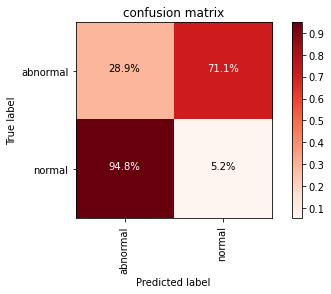

In [9]:
start = datetime.datetime.now()
db = DBSCAN(eps=e_max, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
trainning_time = datetime.datetime.now() - start
print(f"trainning dbscan in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))